In [1]:
import os
print(os.listdir("/home/coder/IKT464_project"))


['test_labels', 'hold_labels', 'tier1_labels', '.git', 'tier3_labels', '.venv', 'DatasetConnection.ipynb']


In [ ]:
import os, json
from pathlib import Path

base = Path("/home/coder/IKT464_project/tier1_labels")

if not base.exists():
    raise FileNotFoundError(f"Folder not found: {base}")

# Find all *.json where filename contains 'post' (case-insensitive), searching subfolders too
matches = [p for p in base.rglob("*.json") if "post" in p.name.lower()]

print(f"Found {len(matches)} JSON files containing 'post' under {base}")
for p in matches[:10]:  # preview first 10 matches
    print("  -", p.relative_to(base))

# === Process them (example: print top-level keys, with error handling) ===
for p in matches:
    try:
        with open(p, encoding="utf-8") as f:
            data = json.load(f)
        # ---- your processing code here ----
        print(f"✅ {p.name} | keys: {list(data.keys())[:10]}")
    except Exception as e:
        print(f"⚠️ Skipped {p} due to error: {e}")


In [4]:
!uv pip install pandas shapely pyproj

Using Python 3.13.7 environment at: /home/coder/.venv
Audited 3 packages in 71ms


In [4]:
from pathlib import Path
import json
from typing import Dict, Any, List, Optional
from shapely import wkt as shapely_wkt
from shapely.geometry import Polygon, MultiPolygon, LinearRing
from pyproj import Geod

# ---------------------------------------------------------------------
# Folder
directory = Path("/home/coder/IKT464_project/tier1_labels")

# ---- Helpers ----------------------------------------------------------------
DEGREE_MAP = {
    "no damage": 0,  "no-damage": 0,  "nodamage": 0,
    "minor damage": 1, "minor-damage": 1, "minordamage": 1,
    "major damage": 2, "major-damage": 2, "majordamage": 2,
    "destroyed": 3
}


def subtype_to_degree(value: Optional[str]) -> int:
    if not value:
        return 0
    key = str(value).strip().lower().replace("_", " ")
    key = " ".join(key.split())
    return DEGREE_MAP.get(key, DEGREE_MAP.get(key.replace(" ", "-"), 0))

def _ring_lonlat(ring: LinearRing):
    """Return (lons, lats) and ensure ring is closed."""
    coords = list(ring.coords)
    if coords and coords[0] != coords[-1]:
        coords.append(coords[0])
    lons, lats = zip(*coords) if coords else ([], [])
    return lons, lats

def geodesic_area_m2(geom, geod: Geod) -> float:
    """Compute polygon area (m²) on WGS84 geoid. Handles holes and multipolygons."""
    if isinstance(geom, Polygon):
        if geom.is_empty:
            return 0.0
        ex_lons, ex_lats = _ring_lonlat(geom.exterior)
        if not ex_lons:
            return 0.0
        ext_area, _ = geod.polygon_area_perimeter(ex_lons, ex_lats)
        area = abs(ext_area)
        for interior in geom.interiors:
            in_lons, in_lats = _ring_lonlat(interior)
            if not in_lons:
                continue
            hole_area, _ = geod.polygon_area_perimeter(in_lons, in_lats)
            area -= abs(hole_area)
        return max(area, 0.0)
    if isinstance(geom, MultiPolygon):
        return sum(geodesic_area_m2(p, geod) for p in geom.geoms)
    return 0.0

# ---- Main -------------------------------------------------------------------
def collect_weighted_areas_with_disaster(json_dir: Path) -> Dict[str, Dict[str, Any]]:
    """
    For each *.json containing 'post' in its filename:
      - Read metadata.disaster_type
      - For each features['lng_lat'] feature:
          * Parse WKT geometry
          * Compute geodesic area (m²) on WGS84
          * Multiply area by subtype degree (0..4)

    Returns a dict keyed by filename:
      {
        "<file>.json": {
          "disaster_type": <str or None>,
          "areas": [area_m2, ...],                  # per-feature plain areas
          "values": [area_m2 * degree, ...],        # per-feature weighted areas
          "total_area_m2": <float>,                 # sum(areas)
          "total_weighted_area": <float>            # sum(values)
        },
        ...
      }
    """
    geod = Geod(ellps="WGS84")
    results: Dict[str, Dict[str, Any]] = {}

    for file in json_dir.glob("*.json"):
        if "post" not in file.name.lower():
            continue

        try:
            with open(file, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[ERROR] {file.name}: failed to read JSON - {e}")
            continue

        disaster_type = (data.get("metadata") or {}).get("disaster_type")
        features = (data.get("features") or {}).get("lng_lat", [])
        values: List[float] = []
        areas: List[float] = []

        for feat in features:
            try:
                props = feat.get("properties") or {}
                subtype = props.get("subtype", "")
                degree = subtype_to_degree(subtype)

                wkt_str = feat.get("wkt")
                if not wkt_str:
                    raise ValueError("Missing 'wkt' in feature")

                geom = shapely_wkt.loads(wkt_str)
                area_m2 = geodesic_area_m2(geom, geod)
                weighted = area_m2 * degree

                areas.append(area_m2)
                values.append(weighted)

            except Exception as e:
                print(f"[WARN] {file.name}: feature skipped - {e}")

        results[file.name] = {
            "disaster_type": disaster_type,
            "areas": areas,
            "values": values,
            "total_area_m2": float(sum(areas)),
            "total_weighted_area": float(sum(values)),
        }

    return results

# ---- Run --------------------------------------------------------------------
weighted_areas_with_disaster = collect_weighted_areas_with_disaster(directory)

# ---- Quick peek -------------------------------------------------------------
for fname, info in list(weighted_areas_with_disaster.items())[:5]:
    print(
        f"{fname} | disaster_type={info['disaster_type']} | "
        f"{len(info['values'])} items | "
        f"area={info['total_area_m2']:.2f} m² | "
        f"weighted={info['total_weighted_area']:.2f} m²"
    )


socal-fire_00001112_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m²
socal-fire_00001259_post_disaster.json | disaster_type=fire | 14 items | area=1246.75 m² | weighted=2731.98 m²
hurricane-harvey_00000348_post_disaster.json | disaster_type=flooding | 5 items | area=19682.14 m² | weighted=0.00 m²
socal-fire_00000402_post_disaster.json | disaster_type=fire | 6 items | area=1045.01 m² | weighted=72.39 m²
hurricane-harvey_00000289_post_disaster.json | disaster_type=flooding | 44 items | area=3182.45 m² | weighted=6856.35 m²


In [8]:
from pathlib import Path
import pandas as pd
from openpyxl import load_workbook

directory = Path("/home/coder/IKT464_project/tier1_labels")
excel_path = Path("/home/coder/IKT464_project/dataset_info.xlsx")

# Build rows for Excel
rows = []
for fname, info in weighted_areas_with_disaster.items():
    rows.append({
        "filename": fname,
        "disaster_type": info.get("disaster_type"),
        "items": len(info.get("values", [])),
        "area_m2": float(info.get("total_area_m2", 0.0)),
        "weighted_m2": float(info.get("total_weighted_area", 0.0)),
        "folder": directory.name,  # "tier1_labels"
    })

df = pd.DataFrame(rows)

# Create "pretty" column for readability
df["pretty"] = df.apply(
    lambda r: (
        f"{r['filename']} | disaster_type={r['disaster_type']} | "
        f"{r['items']} items | area={r['area_m2']:.2f} m² | "
        f"weighted={r['weighted_m2']:.2f} m² | {r['folder']}"
    ),
    axis=1,
)

# Append to the existing Excel file without overwriting other sheets
sheet_name = f"quick_peek_{directory.name}"  # e.g. "quick_peek_tier1_labels"

if excel_path.exists():
    # Load existing workbook to append
    with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
        df.to_excel(writer, index=False, sheet_name=sheet_name)
else:
    # Create new workbook if it doesn't exist
    with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
        df.to_excel(writer, index=False, sheet_name=sheet_name)

print(f"✅ Data appended to: {excel_path} (sheet: {sheet_name})")

# Keep your original printout for first 5 entries
for fname, info in list(weighted_areas_with_disaster.items())[:5]:
    print(
        f"{fname} | disaster_type={info['disaster_type']} | "
        f"{len(info['values'])} items | "
        f"area={info['total_area_m2']:.2f} m² | "
        f"weighted={info['total_weighted_area']:.2f} m² | {directory.name}"
    )


✅ Data appended to: /home/coder/IKT464_project/dataset_info.xlsx (sheet: quick_peek_tier1_labels)
socal-fire_00001112_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m² | tier1_labels
socal-fire_00001259_post_disaster.json | disaster_type=fire | 14 items | area=1246.75 m² | weighted=2731.98 m² | tier1_labels
hurricane-harvey_00000348_post_disaster.json | disaster_type=flooding | 5 items | area=19682.14 m² | weighted=0.00 m² | tier1_labels
socal-fire_00000402_post_disaster.json | disaster_type=fire | 6 items | area=1045.01 m² | weighted=72.39 m² | tier1_labels
hurricane-harvey_00000289_post_disaster.json | disaster_type=flooding | 44 items | area=3182.45 m² | weighted=6856.35 m² | tier1_labels


In [10]:
# ---- Aggregate across files by disaster type --------------------------------
def aggregate_by_disaster(results: Dict[str, Dict[str, Any]]) -> Dict[str, Dict[str, float]]:
    agg: Dict[str, Dict[str, float]] = {}
    for info in results.values():
        dtype = info.get("disaster_type") or "unknown"
        entry = agg.setdefault(dtype, {"sum_area_m2": 0.0, "sum_weighted_m2": 0.0})
        entry["sum_area_m2"] += float(info.get("total_area_m2", 0.0))
        entry["sum_weighted_m2"] += float(info.get("total_weighted_area", 0.0))
    # optional ratio
    for v in agg.values():
        v["weighted_per_m2"] = (v["sum_weighted_m2"] / v["sum_area_m2"]) if v["sum_area_m2"] > 0 else None
    return agg

by_disaster = aggregate_by_disaster(weighted_areas_with_disaster)

# ---- Print summary (sorted by sum_weighted_m2 desc) -------------------------
for dtype, stats in sorted(by_disaster.items(), key=lambda kv: kv[1]["sum_weighted_m2"], reverse=True):
    ratio = stats["weighted_per_m2"]
    ratio_str = f"{ratio:.4f}" if ratio is not None else "n/a"
    print(
        f"{dtype}: sum(weighted)={stats['sum_weighted_m2']:.2f} m²  |  "
        f"sum(area)={stats['sum_area_m2']:.2f} m²  |  weighted/area={ratio_str}"
    )


flooding: sum(weighted)=7158884.66 m²  |  sum(area)=11771660.06 m²  |  weighted/area=0.6081
wind: sum(weighted)=5033517.59 m²  |  sum(area)=7317167.05 m²  |  weighted/area=0.6879
fire: sum(weighted)=3345624.15 m²  |  sum(area)=5653660.05 m²  |  weighted/area=0.5918
tsunami: sum(weighted)=1897509.37 m²  |  sum(area)=4405680.69 m²  |  weighted/area=0.4307
earthquake: sum(weighted)=53566.41 m²  |  sum(area)=7617494.42 m²  |  weighted/area=0.0070
volcano: sum(weighted)=9842.00 m²  |  sum(area)=91052.10 m²  |  weighted/area=0.1081


In [20]:
!uv pip install matplotlib


Using Python 3.13.7 environment at: /home/coder/.venv
Resolved 11 packages in 347ms                                        
⠙ Preparing packages... (0/6)                                                   
⠙ Preparing packages... (0/6)--------------     0 B/8.13 KiB            
⠙ Preparing packages... (0/6)---------- 8.13 KiB/8.13 KiB           
⠙ Preparing packages... (0/6)---------- 8.13 KiB/8.13 KiB           
cycler               ------------------------------ 8.13 KiB/8.13 KiB
⠙ Preparing packages... (0/6)--------------     0 B/111.22 KiB          
cycler               ------------------------------ 8.13 KiB/8.13 KiB
⠙ Preparing packages... (0/6)-------------- 16.00 KiB/111.22 KiB        
cycler               ------------------------------ 8.13 KiB/8.13 KiB
⠙ Preparing packages... (0/6)-------------- 32.00 KiB/111.22 KiB        
cycler               ------------------------------ 8.13 KiB/8.13 KiB
⠙ Preparing packages... (0/6)-------------- 48.00 KiB/111.22 KiB        
cycler      

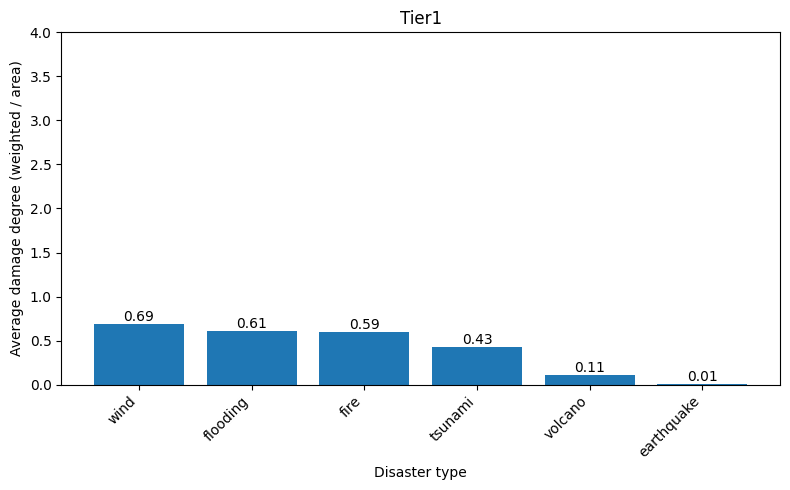

In [11]:
import matplotlib.pyplot as plt

# If you haven't run aggregate_by_disaster yet, uncomment:
# by_disaster = aggregate_by_disaster(weighted_areas_with_disaster)

# Build labels and ratios (skip types with zero area)
labels = []
ratios = []
for dtype, stats in by_disaster.items():
    area = stats.get("sum_area_m2", 0.0)
    weighted = stats.get("sum_weighted_m2", 0.0)
    if area > 0:
        labels.append(str(dtype))
        ratios.append(weighted / area)

# (Optional) sort by ratio descending for a cleaner chart
order = sorted(range(len(labels)), key=lambda i: ratios[i], reverse=True)
labels = [labels[i] for i in order]
ratios = [ratios[i] for i in order]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, ratios)  # no colors/styles per your constraints
plt.ylabel("Average damage degree (weighted / area)")
plt.xlabel("Disaster type")
plt.title("Tier1")
plt.ylim(0, 4)  # degree scale is 0–4
plt.xticks(rotation=45, ha="right")

# Annotate bars with values
for i, v in enumerate(ratios):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [12]:
directory_tier3labels = Path("/home/coder/IKT464_project/tier3_labels")

weighted_areas_with_disaster = collect_weighted_areas_with_disaster(directory_tier3labels)

# ---- Quick peek -------------------------------------------------------------
for fname, info in list(weighted_areas_with_disaster.items())[:5]:
    print(
        f"{fname} | disaster_type={info['disaster_type']} | "
        f"{len(info['values'])} items | "
        f"area={info['total_area_m2']:.2f} m² | "
        f"weighted={info['total_weighted_area']:.2f} m²"
    )

nepal-flooding_00000415_post_disaster.json | disaster_type=flooding | 14 items | area=543.32 m² | weighted=1086.64 m²
pinery-bushfire_00000192_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m²
pinery-bushfire_00001084_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m²
joplin-tornado_00000023_post_disaster.json | disaster_type=wind | 47 items | area=16186.53 m² | weighted=0.00 m²
portugal-wildfire_00000630_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m²


In [13]:
from pathlib import Path
import pandas as pd
from openpyxl import load_workbook

directory = Path("/home/coder/IKT464_project/tier3_labels")
excel_path = Path("/home/coder/IKT464_project/dataset_info.xlsx")

# Build rows for Excel
rows = []
for fname, info in weighted_areas_with_disaster.items():
    rows.append({
        "filename": fname,
        "disaster_type": info.get("disaster_type"),
        "items": len(info.get("values", [])),
        "area_m2": float(info.get("total_area_m2", 0.0)),
        "weighted_m2": float(info.get("total_weighted_area", 0.0)),
        "folder": directory.name,  # "tier1_labels"
    })

df = pd.DataFrame(rows)

# Create "pretty" column for readability
df["pretty"] = df.apply(
    lambda r: (
        f"{r['filename']} | disaster_type={r['disaster_type']} | "
        f"{r['items']} items | area={r['area_m2']:.2f} m² | "
        f"weighted={r['weighted_m2']:.2f} m² | {r['folder']}"
    ),
    axis=1,
)

# Append to the existing Excel file without overwriting other sheets
sheet_name = f"quick_peek_{directory.name}"  # e.g. "quick_peek_tier1_labels"

if excel_path.exists():
    # Load existing workbook to append
    with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
        df.to_excel(writer, index=False, sheet_name=sheet_name)
else:
    # Create new workbook if it doesn't exist
    with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
        df.to_excel(writer, index=False, sheet_name=sheet_name)

print(f"✅ Data appended to: {excel_path} (sheet: {sheet_name})")

# Keep your original printout for first 5 entries
for fname, info in list(weighted_areas_with_disaster.items())[:5]:
    print(
        f"{fname} | disaster_type={info['disaster_type']} | "
        f"{len(info['values'])} items | "
        f"area={info['total_area_m2']:.2f} m² | "
        f"weighted={info['total_weighted_area']:.2f} m² | {directory.name}"
    )


✅ Data appended to: /home/coder/IKT464_project/dataset_info.xlsx (sheet: quick_peek_tier3_labels)
nepal-flooding_00000415_post_disaster.json | disaster_type=flooding | 14 items | area=543.32 m² | weighted=1086.64 m² | tier3_labels
pinery-bushfire_00000192_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m² | tier3_labels
pinery-bushfire_00001084_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m² | tier3_labels
joplin-tornado_00000023_post_disaster.json | disaster_type=wind | 47 items | area=16186.53 m² | weighted=0.00 m² | tier3_labels
portugal-wildfire_00000630_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m² | tier3_labels


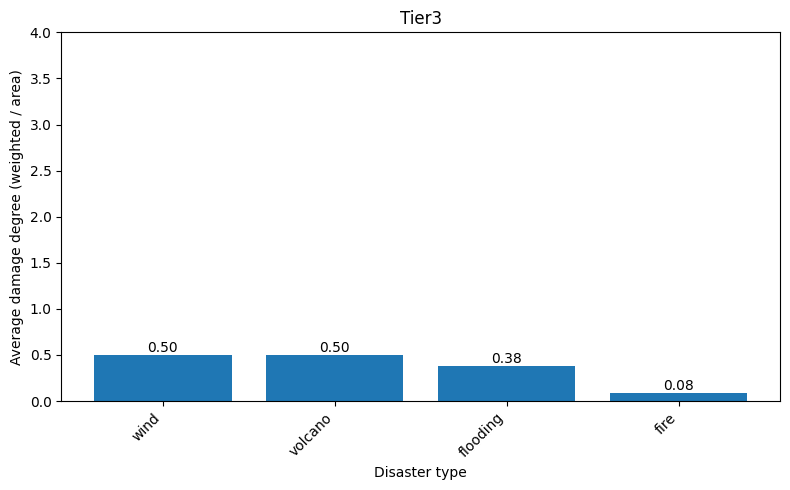

In [15]:
by_disaster = aggregate_by_disaster(weighted_areas_with_disaster)
# Build labels and ratios (skip types with zero area)
labels = []
ratios = []
for dtype, stats in by_disaster.items():
    area = stats.get("sum_area_m2", 0.0)
    weighted = stats.get("sum_weighted_m2", 0.0)
    if area > 0:
        labels.append(str(dtype))
        ratios.append(weighted / area)

# (Optional) sort by ratio descending for a cleaner chart
order = sorted(range(len(labels)), key=lambda i: ratios[i], reverse=True)
labels = [labels[i] for i in order]
ratios = [ratios[i] for i in order]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, ratios)  # no colors/styles per your constraints
plt.ylabel("Average damage degree (weighted / area)")
plt.xlabel("Disaster type")
plt.title("Tier3")
plt.ylim(0, 4)  # degree scale is 0–4
plt.xticks(rotation=45, ha="right")

# Annotate bars with values
for i, v in enumerate(ratios):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [16]:
directory_hold_labels = Path("/home/coder/IKT464_project/hold_labels")

weighted_areas_with_disaster = collect_weighted_areas_with_disaster(directory_hold_labels)

# ---- Quick peek -------------------------------------------------------------
for fname, info in list(weighted_areas_with_disaster.items())[:5]:
    print(
        f"{fname} | disaster_type={info['disaster_type']} | "
        f"{len(info['values'])} items | "
        f"area={info['total_area_m2']:.2f} m² | "
        f"weighted={info['total_weighted_area']:.2f} m²"
    )

hurricane-florence_00000280_post_disaster.json | disaster_type=flooding | 14 items | area=3522.40 m² | weighted=0.00 m²
palu-tsunami_00000029_post_disaster.json | disaster_type=tsunami | 126 items | area=20285.11 m² | weighted=33969.99 m²
socal-fire_00001155_post_disaster.json | disaster_type=fire | 5 items | area=2050.30 m² | weighted=0.00 m²
socal-fire_00001068_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m²
santa-rosa-wildfire_00000157_post_disaster.json | disaster_type=fire | 271 items | area=54407.20 m² | weighted=163221.60 m²


In [17]:


directory = Path("/home/coder/IKT464_project/hold_labels")
excel_path = Path("/home/coder/IKT464_project/dataset_info.xlsx")

# Build rows for Excel
rows = []
for fname, info in weighted_areas_with_disaster.items():
    rows.append({
        "filename": fname,
        "disaster_type": info.get("disaster_type"),
        "items": len(info.get("values", [])),
        "area_m2": float(info.get("total_area_m2", 0.0)),
        "weighted_m2": float(info.get("total_weighted_area", 0.0)),
        "folder": directory.name,  # "tier1_labels"
    })

df = pd.DataFrame(rows)

# Create "pretty" column for readability
df["pretty"] = df.apply(
    lambda r: (
        f"{r['filename']} | disaster_type={r['disaster_type']} | "
        f"{r['items']} items | area={r['area_m2']:.2f} m² | "
        f"weighted={r['weighted_m2']:.2f} m² | {r['folder']}"
    ),
    axis=1,
)

# Append to the existing Excel file without overwriting other sheets
sheet_name = f"quick_peek_{directory.name}"  # e.g. "quick_peek_tier1_labels"

if excel_path.exists():
    # Load existing workbook to append
    with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
        df.to_excel(writer, index=False, sheet_name=sheet_name)
else:
    # Create new workbook if it doesn't exist
    with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
        df.to_excel(writer, index=False, sheet_name=sheet_name)

print(f"✅ Data appended to: {excel_path} (sheet: {sheet_name})")

# Keep your original printout for first 5 entries
for fname, info in list(weighted_areas_with_disaster.items())[:5]:
    print(
        f"{fname} | disaster_type={info['disaster_type']} | "
        f"{len(info['values'])} items | "
        f"area={info['total_area_m2']:.2f} m² | "
        f"weighted={info['total_weighted_area']:.2f} m² | {directory.name}"
    )


✅ Data appended to: /home/coder/IKT464_project/dataset_info.xlsx (sheet: quick_peek_hold_labels)
hurricane-florence_00000280_post_disaster.json | disaster_type=flooding | 14 items | area=3522.40 m² | weighted=0.00 m² | hold_labels
palu-tsunami_00000029_post_disaster.json | disaster_type=tsunami | 126 items | area=20285.11 m² | weighted=33969.99 m² | hold_labels
socal-fire_00001155_post_disaster.json | disaster_type=fire | 5 items | area=2050.30 m² | weighted=0.00 m² | hold_labels
socal-fire_00001068_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m² | hold_labels
santa-rosa-wildfire_00000157_post_disaster.json | disaster_type=fire | 271 items | area=54407.20 m² | weighted=163221.60 m² | hold_labels


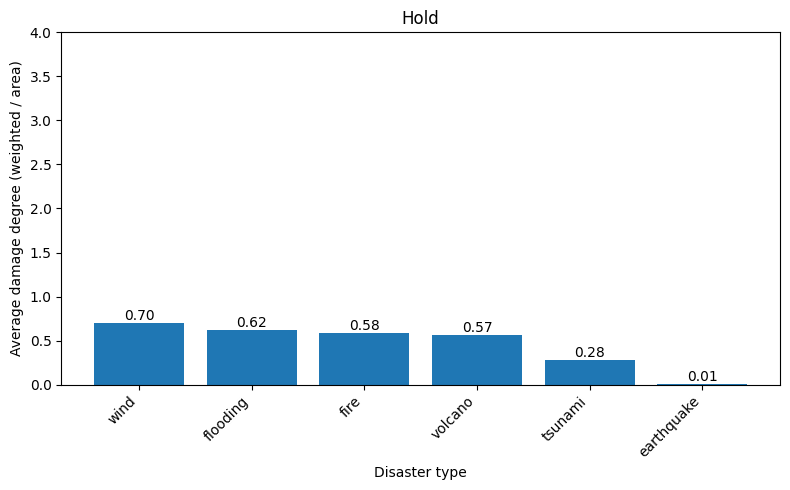

In [18]:
by_disaster = aggregate_by_disaster(weighted_areas_with_disaster)
# Build labels and ratios (skip types with zero area)
labels = []
ratios = []
for dtype, stats in by_disaster.items():
    area = stats.get("sum_area_m2", 0.0)
    weighted = stats.get("sum_weighted_m2", 0.0)
    if area > 0:
        labels.append(str(dtype))
        ratios.append(weighted / area)

# (Optional) sort by ratio descending for a cleaner chart
order = sorted(range(len(labels)), key=lambda i: ratios[i], reverse=True)
labels = [labels[i] for i in order]
ratios = [ratios[i] for i in order]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, ratios)  # no colors/styles per your constraints
plt.ylabel("Average damage degree (weighted / area)")
plt.xlabel("Disaster type")
plt.title("Hold")
plt.ylim(0, 4)  # degree scale is 0–4
plt.xticks(rotation=45, ha="right")

# Annotate bars with values
for i, v in enumerate(ratios):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [19]:
directory_test_labels = Path("/home/coder/IKT464_project/test_labels")

weighted_areas_with_disaster = collect_weighted_areas_with_disaster(directory_test_labels)

# ---- Quick peek -------------------------------------------------------------
for fname, info in list(weighted_areas_with_disaster.items())[:5]:
    print(
        f"{fname} | disaster_type={info['disaster_type']} | "
        f"{len(info['values'])} items | "
        f"area={info['total_area_m2']:.2f} m² | "
        f"weighted={info['total_weighted_area']:.2f} m²"
    )

midwest-flooding_00000256_post_disaster.json | disaster_type=flooding | 187 items | area=16161.58 m² | weighted=0.00 m²
midwest-flooding_00000112_post_disaster.json | disaster_type=flooding | 8 items | area=862.45 m² | weighted=0.00 m²
hurricane-michael_00000375_post_disaster.json | disaster_type=wind | 0 items | area=0.00 m² | weighted=0.00 m²
hurricane-matthew_00000135_post_disaster.json | disaster_type=wind | 22 items | area=1326.28 m² | weighted=3085.48 m²
socal-fire_00000613_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m²


In [20]:


directory = Path("/home/coder/IKT464_project/test_labels")
excel_path = Path("/home/coder/IKT464_project/dataset_info.xlsx")

# Build rows for Excel
rows = []
for fname, info in weighted_areas_with_disaster.items():
    rows.append({
        "filename": fname,
        "disaster_type": info.get("disaster_type"),
        "items": len(info.get("values", [])),
        "area_m2": float(info.get("total_area_m2", 0.0)),
        "weighted_m2": float(info.get("total_weighted_area", 0.0)),
        "folder": directory.name,  # "tier1_labels"
    })

df = pd.DataFrame(rows)

# Create "pretty" column for readability
df["pretty"] = df.apply(
    lambda r: (
        f"{r['filename']} | disaster_type={r['disaster_type']} | "
        f"{r['items']} items | area={r['area_m2']:.2f} m² | "
        f"weighted={r['weighted_m2']:.2f} m² | {r['folder']}"
    ),
    axis=1,
)

# Append to the existing Excel file without overwriting other sheets
sheet_name = f"quick_peek_{directory.name}"  # e.g. "quick_peek_tier1_labels"

if excel_path.exists():
    # Load existing workbook to append
    with pd.ExcelWriter(excel_path, engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
        df.to_excel(writer, index=False, sheet_name=sheet_name)
else:
    # Create new workbook if it doesn't exist
    with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
        df.to_excel(writer, index=False, sheet_name=sheet_name)

print(f"✅ Data appended to: {excel_path} (sheet: {sheet_name})")

# Keep your original printout for first 5 entries
for fname, info in list(weighted_areas_with_disaster.items())[:5]:
    print(
        f"{fname} | disaster_type={info['disaster_type']} | "
        f"{len(info['values'])} items | "
        f"area={info['total_area_m2']:.2f} m² | "
        f"weighted={info['total_weighted_area']:.2f} m² | {directory.name}"
    )


✅ Data appended to: /home/coder/IKT464_project/dataset_info.xlsx (sheet: quick_peek_test_labels)
midwest-flooding_00000256_post_disaster.json | disaster_type=flooding | 187 items | area=16161.58 m² | weighted=0.00 m² | test_labels
midwest-flooding_00000112_post_disaster.json | disaster_type=flooding | 8 items | area=862.45 m² | weighted=0.00 m² | test_labels
hurricane-michael_00000375_post_disaster.json | disaster_type=wind | 0 items | area=0.00 m² | weighted=0.00 m² | test_labels
hurricane-matthew_00000135_post_disaster.json | disaster_type=wind | 22 items | area=1326.28 m² | weighted=3085.48 m² | test_labels
socal-fire_00000613_post_disaster.json | disaster_type=fire | 0 items | area=0.00 m² | weighted=0.00 m² | test_labels


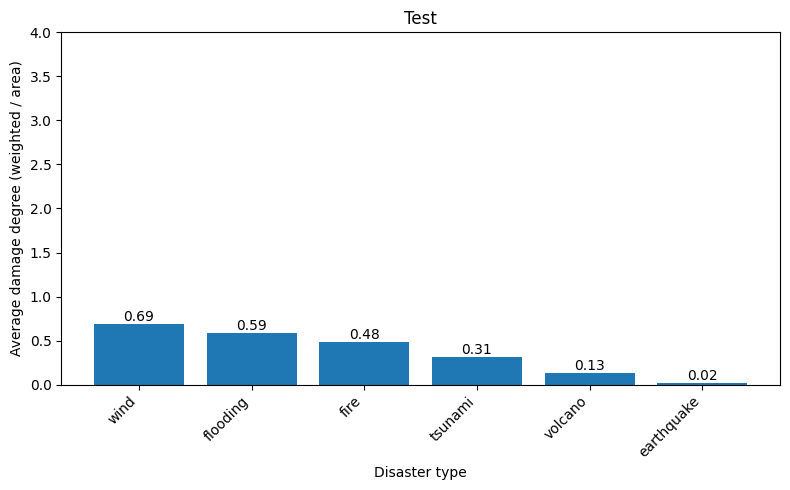

In [21]:
by_disaster = aggregate_by_disaster(weighted_areas_with_disaster)
# Build labels and ratios (skip types with zero area)
labels = []
ratios = []
for dtype, stats in by_disaster.items():
    area = stats.get("sum_area_m2", 0.0)
    weighted = stats.get("sum_weighted_m2", 0.0)
    if area > 0:
        labels.append(str(dtype))
        ratios.append(weighted / area)

# (Optional) sort by ratio descending for a cleaner chart
order = sorted(range(len(labels)), key=lambda i: ratios[i], reverse=True)
labels = [labels[i] for i in order]
ratios = [ratios[i] for i in order]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, ratios)  # no colors/styles per your constraints
plt.ylabel("Average damage degree (weighted / area)")
plt.xlabel("Disaster type")
plt.title("Test")
plt.ylim(0, 4)  # degree scale is 0–4
plt.xticks(rotation=45, ha="right")

# Annotate bars with values
for i, v in enumerate(ratios):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()
